In [1]:
import cv2
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
import os
from PIL import Image, ImageFile
from torch.utils.data import Dataset
import torch
import torch.optim as optim
import torchvision.transforms as transsforms
from tqdm import tqdm

from torchvision import transforms
from torch.optim import lr_scheduler

In [2]:
class PupilDataset(Dataset):

    def __init__(self, pt, transform=None):
        self.pt = pt
        self.transform = transform

    def __len__(self):
        return len(self.pt)

    def __getitem__(self, idx):
        img_name = self.pt[idx]    
        image = Image.open(img_name)
        label = torch.tensor(train_csv.loc[idx,[2,3]].values.astype(np.float16))
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
train_list = np.array([os.path.join(d, x) for d, dirs, files in os.walk('./train/') for x in files if x.endswith('.jpg')])
test_list = np.array([os.path.join(d, x) for d, dirs, files in os.walk('./test/') for x in files if x.endswith('.jpg')])
val_list = np.array([os.path.join(d, x) for d, dirs, files in os.walk('./val/') for x in files if x.endswith('.jpg')])

In [4]:
train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

trainset     = PupilDataset(train_list, transform =train_tf)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers=0)
valset       = PupilDataset(val_list, transform =train_tf)
testset       = PupilDataset(test_list, transform =train_tf)
val_loader   = torch.utils.data.DataLoader(valset, batch_size=8, shuffle=False, num_workers=0)

In [5]:
train_csv = pd.read_csv('./target50_clustered.csv', header = None)
clusters = train_csv[4].values

In [6]:
x = 640/224
y = 480 / 224

train_csv[2] = train_csv[2] / x
train_csv[3] = train_csv[3] / y 

In [7]:
num_classes = 2
lr          = 1e-3
IMG_SIZE    = 256

In [8]:
from efficientnet_pytorch import EfficientNet
from torch.optim import Adam, SGD, RMSprop
import torch.nn.init as init
import torch
import torch.nn as nn

model = EfficientNet.from_pretrained('efficientnet-b0') 
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)
model.load_state_dict(torch.load("./weight_best_b0_st.pt"))
model.cuda()

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [9]:
for param in model.parameters():
    param.requires_grad = False

model.eval()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [10]:
device = torch.device("cuda:0")

In [11]:
test_data_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)
test_preds = np.zeros((len(test_list), 2))
tk = tqdm(test_data_loader)
for i, x_batch in enumerate(tk):
    x_batch = x_batch[0]
    pred = model(x_batch.to(device))
    test_preds[i * 32:(i + 1) * 32] = pred.detach().cpu().numpy()



100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:11<00:00,  2.19it/s]


In [23]:
test_list[0].split('/')[2].split('.')[0]

'10_11_0'

In [35]:
train_csv[1]

0           1_1_0
1          1_1_50
2         1_1_100
3         1_1_150
4         1_1_200
5         1_1_250
6         1_1_300
7         1_1_350
8         1_1_400
9         1_1_450
10        1_1_500
11        1_1_550
12        1_1_600
13        1_1_650
14        1_1_700
15        1_1_750
16        1_1_800
17        1_1_850
18        1_1_900
19        1_1_950
20       1_1_1000
21       1_1_1050
22       1_1_1100
23       1_1_1150
24       1_1_1200
25       1_1_1250
26       1_1_1300
27       1_1_1350
28       1_1_1400
29       1_1_1450
          ...    
2588     9_18_500
2589     9_18_550
2590     9_18_600
2591     9_18_650
2592     9_18_700
2593     9_18_750
2594     9_18_800
2595     9_18_850
2596     9_18_900
2597     9_18_950
2598    9_18_1000
2599    9_18_1050
2600    9_18_1100
2601    9_18_1150
2602    9_18_1200
2603    9_18_1250
2604    9_18_1300
2605    9_18_1350
2606    9_18_1400
2607    9_18_1450
2608    9_18_1500
2609    9_18_1550
2610    9_18_1600
2611    9_18_1650
2612    9_

In [97]:
test = []

for x in test_list:
    x = x.split('/')[2].split('.')[0]
    test.append(x)

In [98]:
test = train_csv[train_csv[1].isin(test)].loc[:,[2,3]]

In [100]:
from torch.nn.modules.distance import PairwiseDistance
res = PairwiseDistance(2).forward(torch.tensor(test.values),torch.tensor(test_preds))

In [117]:
fin = []
for x in range(0,150,10):
    fin.append(len(np.where(res < x)[0])/ len(res))

In [118]:
x = range(0,150,10)
y = fin

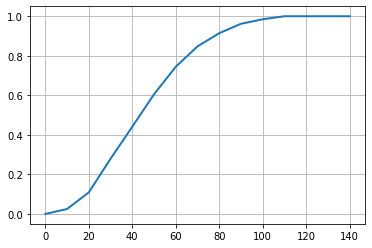

In [119]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(x, y, linewidth=2, markersize=5)

ax.grid()

plt.show()